<a href="https://colab.research.google.com/github/curiosity806/machine-learning-and-practice-report/blob/master/Dacon_satellite_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 데이터 받아오기

In [2]:
# 훈련 데이터
!cp '/content/drive/My Drive/2020 Kaggle Study/data/train.npy' train.npy
!cp '/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/train_orbit.npy' train_orbit.npy

## 1. 필요한 라이브러리 import

필요한 라이브러리를 import합니다.  
 저희는 처음 데이터를 numpy파일로 묶어주는 작업 이외의 모든 작업은 colab에서 진행했습니다.

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings("ignore")

# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

# style 설정
plt.style.use('default')
plt.style.use('seaborn-colorblind')

# basemap 설치
#!apt install proj-bin libproj-dev libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz
#!pip install https://github.com/matplotlib/basemap/archive/master.zip
#from mpl_toolkits.basemap import Basemap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = np.load('train.npy')
train_orbit = np.load('train_orbit.npy')

## 레포트 서론에 들어가는 이미지 생성

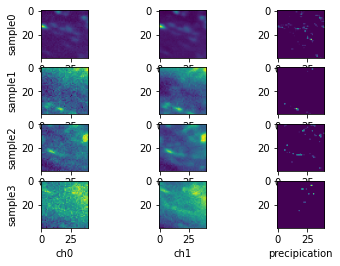

<Figure size 360x1440 with 0 Axes>

In [3]:
fig, axes = plt.subplots(nrows=4, ncols=3)
fig = plt.figure(figsize = (5,20))
for i in range(4):
    for j in range(3):
        if j == 2:
            axes[i,j].imshow(train[i+210,:,:,-1])
        else:
            axes[i,j].imshow(train[i+210,:,:,j])

        if i == 3:
            if j == 2:
                axes[i,j].set_xlabel(f'precipication', size=10)
            else:
                axes[i,j].set_xlabel(f'ch{j}', size=10)
        if j == 0:
            axes[i,j].set_ylabel(f'sample{i}', size=10)
plt.show()

In [4]:
train.shape

(76345, 40, 40, 15)

## train, test split

train은 90%, test는 10% 비율로 split

In [5]:
from sklearn.model_selection import train_test_split
#-------------------------------------------------------------------------------
#강수량 합 100미만 제거
train_labels = []
for i in range(len(train)):
    sample_lable = train[i,:,:,-1].reshape(-1)
    cutoff_labels = np.where(sample_lable < 0, 0, sample_lable)
    if (cutoff_labels > 0).sum() >= 100:
        train_labels.append(i)
train = train[train_labels]
#-------------------------------------------------------------------------------
# feature, target 분리
train = train.reshape([-1,15])
#-------------------------------------------------------------------------------
#train test split
train, test = train_test_split(train, test_size = 0.1, shuffle = True,
                                                    random_state = 1015)

print(train.shape)
print(test.shape)

(30463200, 15)
(3384800, 15)


In [6]:
train = np.where(train<0,0,train)
test = np.where(test<0,0,test)

In [7]:
train.shape

(30463200, 15)

## score함수 생성

In [8]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))
    
def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

In [355]:
outlier

array([[215.04448105,  19.47618407],
       [ 19.47618407, 317.66657995]])

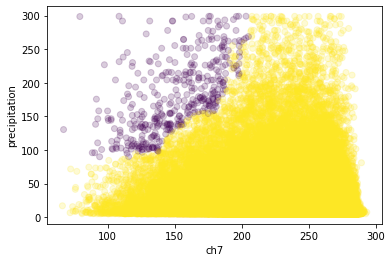

In [343]:
from sklearn.ensemble import IsolationForest
ch = 7
clf = IsolationForest(contamination  = 0.0007)
clf.fit(train_pre[:,[ch,-1]])
outlier = clf.predict(train_pre[:,[ch,-1]])
plt.scatter(x = train_pre[:,ch],y = train_pre[:,-1], c = outlier, alpha = 0.2)
plt.xlabel(f'ch{ch}')
plt.ylabel('precipitation')
plt.show()

In [357]:
train.shape

(30463200, 15)

In [358]:
train_pre.shape

(562312, 15)

In [368]:
print(f'강수량 5 미만 : {100*(train.shape[0] - train_pre.shape[0])/train.shape[0]:2.2f} %')
print(f'강수량 5 이상 :  {100*train_pre.shape[0]/train.shape[0]:2.2f} %')

강수량 5 미만 : 98.15 %
강수량 5 이상 :  1.85 %


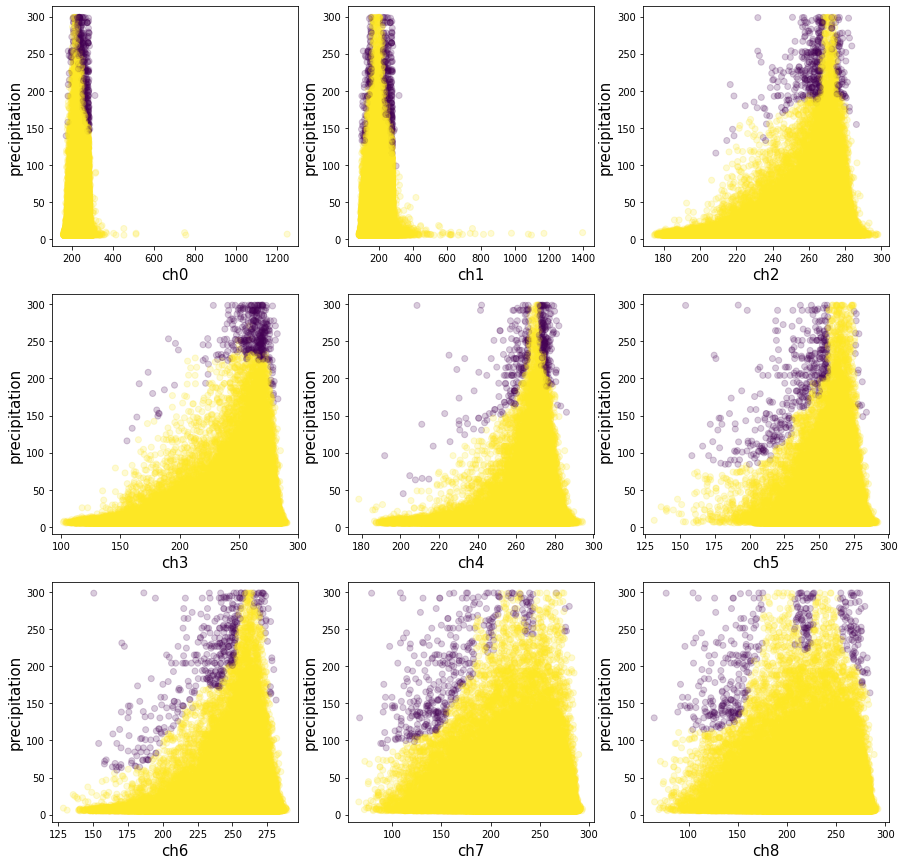

In [350]:
from sklearn.ensemble import IsolationForest

train_pre = train[train[:,-1]>5]
train_pre = train_pre[train_pre[:,-1]<299]


clfs = []
plt.figure(figsize = (15,15))
for ch in range(9):
    clf = IsolationForest(contamination  = 0.0007)
    clf.fit(train_pre[:,[ch,-1]])
    clfs.append(clf)
    plt.subplot(3,3,ch+1)
    outlier = clf.predict(train_pre[:,[ch,-1]])
    plt.scatter(x = train_pre[:,ch],y = train_pre[:,-1], c = outlier, alpha = 0.2)
    plt.xlabel(f'ch{ch}',fontsize=15)
    plt.ylabel('precipitation', fontsize=15)
plt.show()

# 여러가지 모델 시도

classificaiton을 측정하는 f1 score와  
regression을 측정하는 MAE score를 따로따로 측정해보기 ??



## 다항 회귀
- 규제기법 적용해볼것(LASSO, Ridge)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

## SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import make_scorer

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

reg_SVR_Grid_CV = GridSearchCV(estimator=SVR(), param_grid=param_grid, cv= 5, 
                   scoring=make_scorer(maeOverFscore, greater_is_better=False))

reg_SVR_Grid_CV.fit(train_x, train_y)

## 랜덤 포레스트 파라미터 탐색
1. 모델.fit()
2. fold별 스코어

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

param_grid = { 
    'n_estimators': [200, 500],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6],
    #'criterion' :['gini', 'entropy']
}

reg_Randomforest_Grid_CV = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv= 5, 
                   scoring=make_scorer(maeOverFscore, greater_is_better=False))

reg_Randomforest_Grid_CV.fit(train_x, train_y)

In [ ]:
reg_Randomforest_Grid.grid_scores_

In [ ]:
reg_Randomforest_Grid.best_params_

## XGboost Model
- feature_imoportance 추출하기
- gpu 활용하기
- grid search or Randomized search 로 하이퍼 파라미터 튜닝하기

https://towardsdatascience.com/running-xgboost-on-google-colab-free-gpu-a-case-study-841c90fef101

https://thinkalgo.tistory.com/57

In [ ]:
import time
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, XGBModel
from xgboost import plot_importance, plot_tree


# create a default XGBoost classifier
model = XGBClassifier(n_estimators=500, random_state=seed)

# create a default XGBoost classifier
model = XGBClassifier(
    random_state=seed, 
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model = grid.fit(X_train,y_train)

## 차원 축소 적용하기